In [13]:
import argparse
import os
import torch

from utils.print_args import print_args
import random
import numpy as np

from data_provider.data_factory import data_provider
from exp.exp_basic import Exp_Basic
from utils.tools import EarlyStopping, adjust_learning_rate, visual
from utils.metrics import metric
import torch
import torch.nn as nn
from torch import optim
import os
import time
import warnings
import numpy as np
from utils.dtw_metric import dtw,accelerated_dtw
import matplotlib.pyplot as plt
from utils.augmentation import run_augmentation,run_augmentation_single

In [14]:
warnings.filterwarnings('ignore')
class Exp_Long_Term_Forecast(Exp_Basic):
    def __init__(self, args):
        self.gt = 0;
        self.pd = 0;
        super(Exp_Long_Term_Forecast, self).__init__(args)

    def _build_model(self):
        model = self.model_dict[self.args.model].Model(self.args).float()

        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)

                pred = outputs.detach().cpu()
                true = batch_y.detach().cpu()

                loss = criterion(pred, true)

                total_loss.append(loss)
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(flag='train')
        vali_data, vali_loader = self._get_data(flag='val')
        test_data, test_loader = self._get_data(flag='test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()

        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                        f_dim = -1 if self.args.features == 'MS' else 0
                        outputs = outputs[:, -self.args.pred_len:, f_dim:]
                        batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                        loss = criterion(outputs, batch_y)
                        train_loss.append(loss.item())
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                    f_dim = -1 if self.args.features == 'MS' else 0
                    outputs = outputs[:, -self.args.pred_len:, f_dim:]
                    batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                    loss = criterion(outputs, batch_y)
                    train_loss.append(loss.item())

                if (i + 1) % 100 == 0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.args.train_epochs - epoch) * train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()

                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            test_loss = self.vali(test_data, test_loader, criterion)

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch + 1, self.args)

        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))

        return self.model

    def test(self, setting, test=0):
        test_data, test_loader = self._get_data(flag='test')
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        preds = []
        trues = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, :]
                batch_y = batch_y[:, -self.args.pred_len:, :].to(self.device)
                outputs = outputs.detach().cpu().numpy()
                batch_y = batch_y.detach().cpu().numpy()
                if test_data.scale and self.args.inverse:
                    shape = outputs.shape
                    outputs = test_data.inverse_transform(outputs.squeeze(0)).reshape(shape)
                    batch_y = test_data.inverse_transform(batch_y.squeeze(0)).reshape(shape)

                outputs = outputs[:, :, f_dim:]
                batch_y = batch_y[:, :, f_dim:]

                pred = outputs
                true = batch_y

                preds.append(pred)
                trues.append(true)
                if i % 20 == 0:
                    input = batch_x.detach().cpu().numpy()
                    if test_data.scale and self.args.inverse:
                        shape = input.shape
                        input = test_data.inverse_transform(input.squeeze(0)).reshape(shape)
                    gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                    pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
                    self.gt = gt;
                    self.pd = pd;
                    # visual(gt, pd, os.path.join(folder_path, str(i) + '.pdf'))

        preds = np.array(preds)
        trues = np.array(trues)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # dtw calculation
        if self.args.use_dtw:
            dtw_list = []
            manhattan_distance = lambda x, y: np.abs(x - y)
            for i in range(preds.shape[0]):
                x = preds[i].reshape(-1,1)
                y = trues[i].reshape(-1,1)
                if i % 100 == 0:
                    print("calculating dtw iter:", i)
                d, _, _, _ = accelerated_dtw(x, y, dist=manhattan_distance)
                dtw_list.append(d)
            dtw = np.array(dtw_list).mean()
        else:
            dtw = -999


        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}, dtw:{}'.format(mse, mae, dtw))
        f = open("result_long_term_forecast.txt", 'a')
        f.write(setting + "  \n")
        f.write('mse:{}, mae:{}, dtw:{}'.format(mse, mae, dtw))
        f.write('\n')
        f.write('\n')
        f.close()

        np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path + 'pred.npy', preds)
        np.save(folder_path + 'true.npy', trues)

        return

In [15]:
def runrun(model_name):
    fix_seed = 2021
    random.seed(fix_seed)
    torch.manual_seed(fix_seed)
    np.random.seed(fix_seed)

    parser = argparse.ArgumentParser(description='TimesNet')

    # basic config

    parser.add_argument('--root_path', type=str, default='./dataset/weather/', help='root path of the data file')
    parser.add_argument('--data_path', type=str, default='weather.csv', help='data file')
    parser.add_argument('--features', type=str, default='M',
                        help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
    parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
    parser.add_argument('--freq', type=str, default='h',
                        help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
    parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

    # forecasting task
    parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
    parser.add_argument('--label_len', type=int, default=48, help='start token length')
    parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
    parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')
    parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

    # inputation task
    parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')

    # anomaly detection task
    parser.add_argument('--anomaly_ratio', type=float, default=0.25, help='prior anomaly ratio (%)')

    # model define
    parser.add_argument('--expand', type=int, default=2, help='expansion factor for Mamba')
    parser.add_argument('--d_conv', type=int, default=4, help='conv kernel size for Mamba')
    parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
    parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
    parser.add_argument('--enc_in', type=int, default=21, help='encoder input size')
    parser.add_argument('--dec_in', type=int, default=21, help='decoder input size')
    parser.add_argument('--c_out', type=int, default=21, help='output size')
    parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
    parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
    parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
    parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
    parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
    parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
    parser.add_argument('--factor', type=int, default=3, help='attn factor')
    parser.add_argument('--distil', action='store_false',
                        help='whether to use distilling in encoder, using this argument means not using distilling',
                        default=True)
    parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
    parser.add_argument('--embed', type=str, default='timeF',
                        help='time features encoding, options:[timeF, fixed, learned]')
    parser.add_argument('--activation', type=str, default='gelu', help='activation')
    parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
    parser.add_argument('--channel_independence', type=int, default=1,
                        help='0: channel dependence 1: channel independence for FreTS model')
    parser.add_argument('--decomp_method', type=str, default='moving_avg',
                        help='method of series decompsition, only support moving_avg or dft_decomp')
    parser.add_argument('--use_norm', type=int, default=1, help='whether to use normalize; True 1 False 0')
    parser.add_argument('--down_sampling_layers', type=int, default=0, help='num of down sampling layers')
    parser.add_argument('--down_sampling_window', type=int, default=1, help='down sampling window size')
    parser.add_argument('--down_sampling_method', type=str, default=None,
                        help='down sampling method, only support avg, max, conv')
    parser.add_argument('--seg_len', type=int, default=48,
                        help='the length of segmen-wise iteration of SegRNN')

    # optimization
    parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
    parser.add_argument('--itr', type=int, default=1, help='experiments times')
    parser.add_argument('--train_epochs', type=int, default=1, help='train epochs')
    parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
    parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
    parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
    parser.add_argument('--des', type=str, default='Exp', help='exp description')
    parser.add_argument('--loss', type=str, default='MSE', help='loss function')
    parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
    parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

    # GPU
    parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
    parser.add_argument('--gpu', type=int, default=0, help='gpu')
    parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
    parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

    # de-stationary projector params
    parser.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                        help='hidden layer dimensions of projector (List)')
    parser.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')

    # metrics (dtw)
    parser.add_argument('--use_dtw', type=bool, default=False,
                        help='the controller of using dtw metric (dtw is time consuming, not suggested unless necessary)')

    # Augmentation
    parser.add_argument('--augmentation_ratio', type=int, default=0, help="How many times to augment")
    parser.add_argument('--seed', type=int, default=2, help="Randomization seed")
    parser.add_argument('--jitter', default=False, action="store_true", help="Jitter preset augmentation")
    parser.add_argument('--scaling', default=False, action="store_true", help="Scaling preset augmentation")
    parser.add_argument('--permutation', default=False, action="store_true", help="Equal Length Permutation preset augmentation")
    parser.add_argument('--randompermutation', default=False, action="store_true", help="Random Length Permutation preset augmentation")
    parser.add_argument('--magwarp', default=False, action="store_true", help="Magnitude warp preset augmentation")
    parser.add_argument('--timewarp', default=False, action="store_true", help="Time warp preset augmentation")
    parser.add_argument('--windowslice', default=False, action="store_true", help="Window slice preset augmentation")
    parser.add_argument('--windowwarp', default=False, action="store_true", help="Window warp preset augmentation")
    parser.add_argument('--rotation', default=False, action="store_true", help="Rotation preset augmentation")
    parser.add_argument('--spawner', default=False, action="store_true", help="SPAWNER preset augmentation")
    parser.add_argument('--dtwwarp', default=False, action="store_true", help="DTW warp preset augmentation")
    parser.add_argument('--shapedtwwarp', default=False, action="store_true", help="Shape DTW warp preset augmentation")
    parser.add_argument('--wdba', default=False, action="store_true", help="Weighted DBA preset augmentation")
    parser.add_argument('--discdtw', default=False, action="store_true", help="Discrimitive DTW warp preset augmentation")
    parser.add_argument('--discsdtw', default=False, action="store_true", help="Discrimitive shapeDTW warp preset augmentation")
    parser.add_argument('--extra_tag', type=str, default="", help="Anything extra")

    args = parser.parse_args(args=[])
    # args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
    args.use_gpu = True if torch.cuda.is_available() else False

    print(torch.cuda.is_available())

    if args.use_gpu and args.use_multi_gpu:
        args.devices = args.devices.replace(' ', '')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]

    print('Args in experiment:')
    args.model = model_name
    args.task_name = "long_term_forecast"
    args.is_training = 1
    args.model_id = 'weather_96_96'
    args.data = 'custom'





    if args.task_name == 'long_term_forecast':
        Exp = Exp_Long_Term_Forecast
    elif args.task_name == 'short_term_forecast':
        Exp = Exp_Short_Term_Forecast
    elif args.task_name == 'imputation':
        Exp = Exp_Imputation
    elif args.task_name == 'anomaly_detection':
        Exp = Exp_Anomaly_Detection
    elif args.task_name == 'classification':
        Exp = Exp_Classification
    else:
        Exp = Exp_Long_Term_Forecast

    if args.is_training:
        for ii in range(args.itr):
            # setting record of experiments
            exp = Exp(args)  # set experiments
            setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_expand{}_dc{}_fc{}_eb{}_dt{}_{}_{}'.format(
                args.task_name,
                args.model_id,
                args.model,
                args.data,
                args.features,
                args.seq_len,
                args.label_len,
                args.pred_len,
                args.d_model,
                args.n_heads,
                args.e_layers,
                args.d_layers,
                args.d_ff,
                args.expand,
                args.d_conv,
                args.factor,
                args.embed,
                args.distil,
                args.des, ii)

            print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
            exp.train(setting)

            print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
            exp.test(setting)
            torch.cuda.empty_cache()
        exp2 = exp
    else:
        ii = 0
        setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_expand{}_dc{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.task_name,
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.expand,
            args.d_conv,
            args.factor,
            args.embed,
            args.distil,
            args.des, ii)

        exp = Exp(args)  # set experiments
        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting, test=1)
        torch.cuda.empty_cache()

    return(exp2)

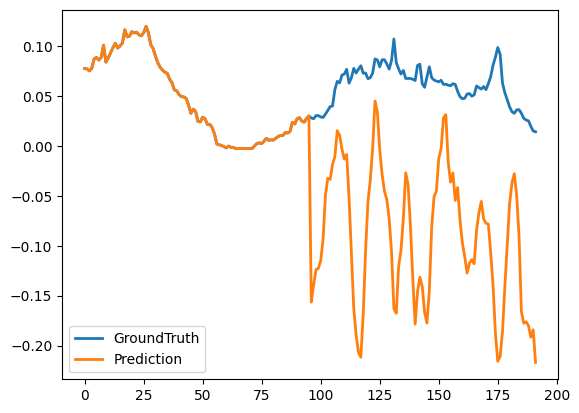

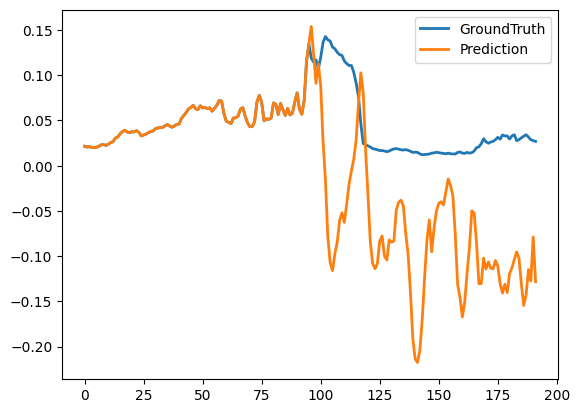

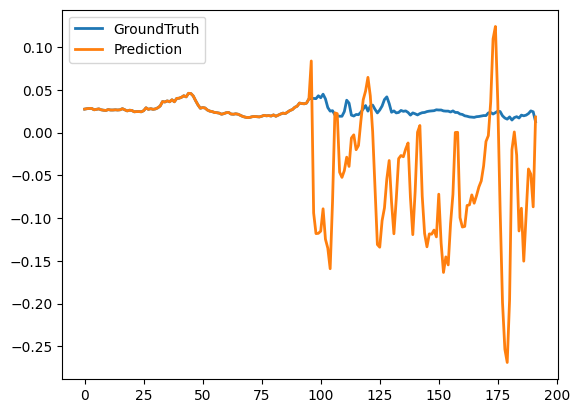

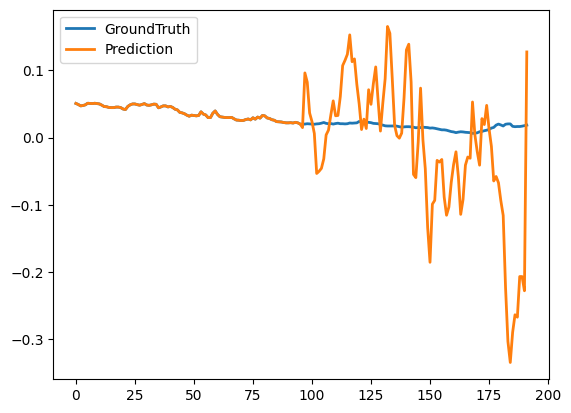

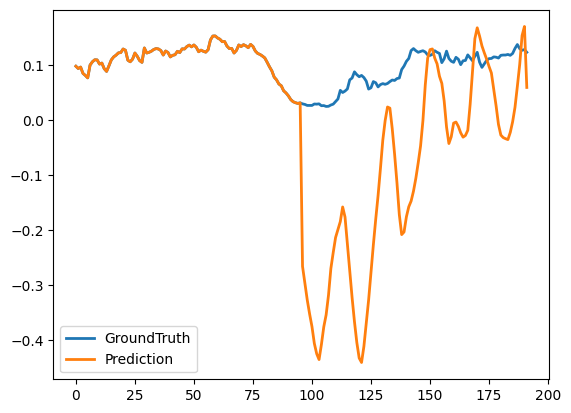

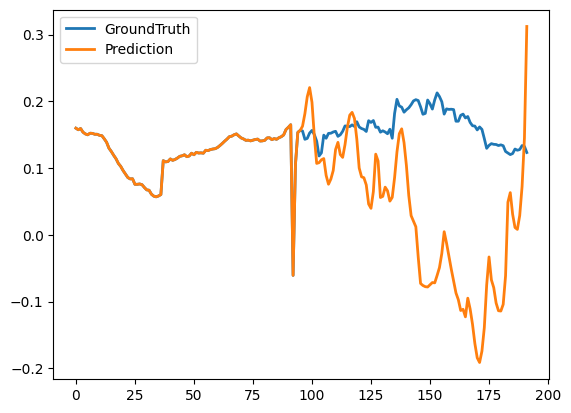

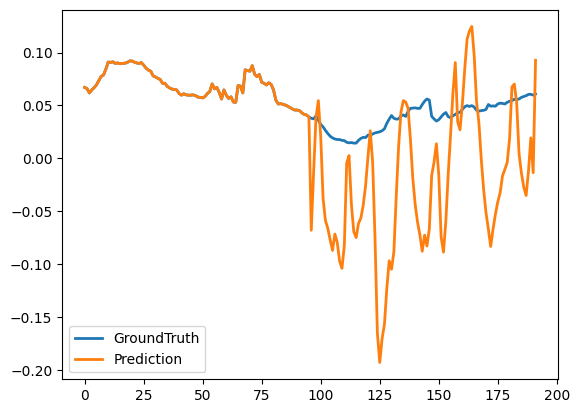

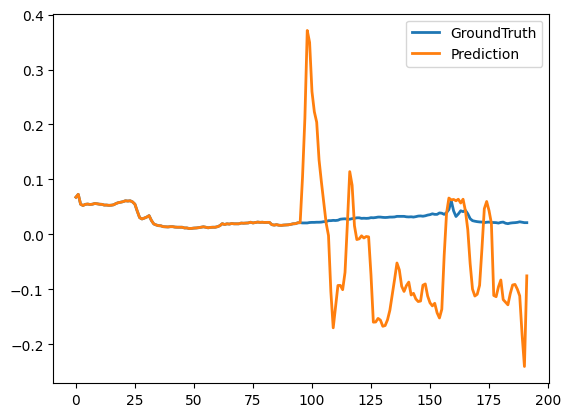

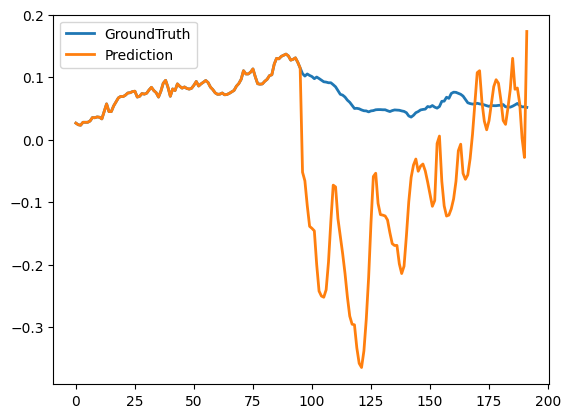

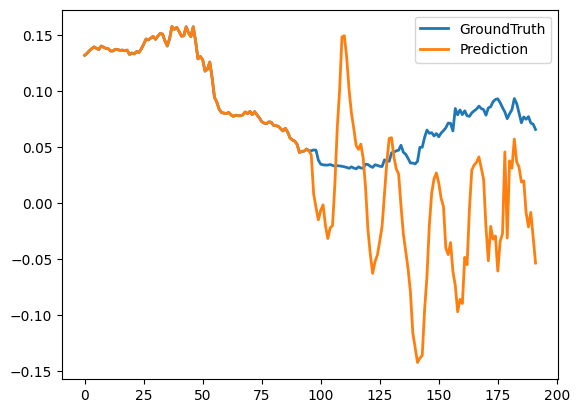

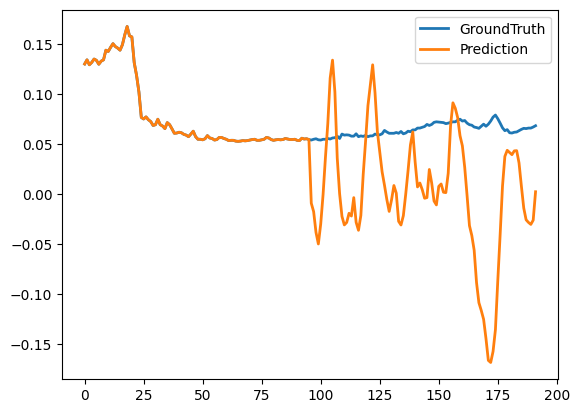

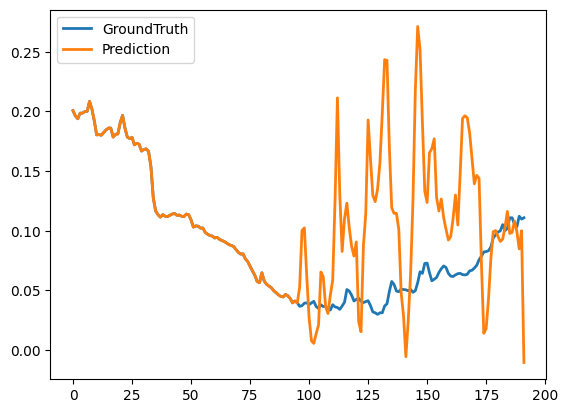

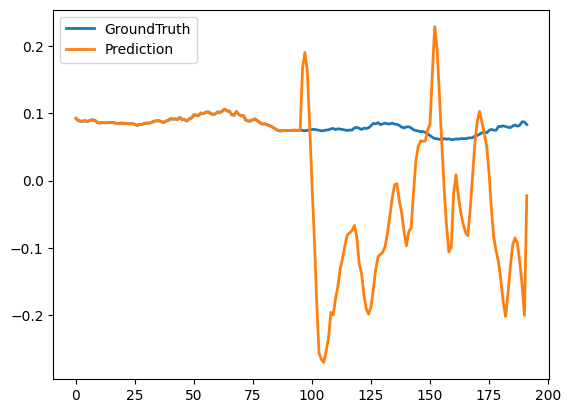

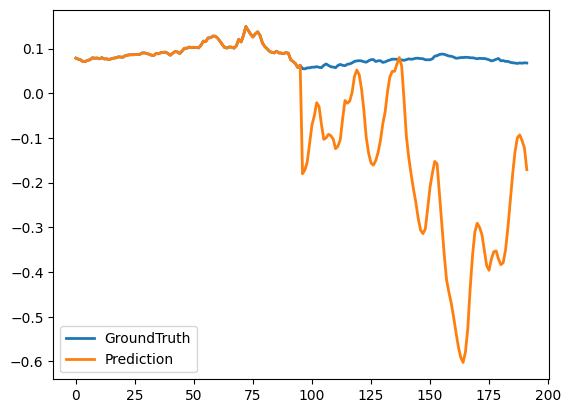

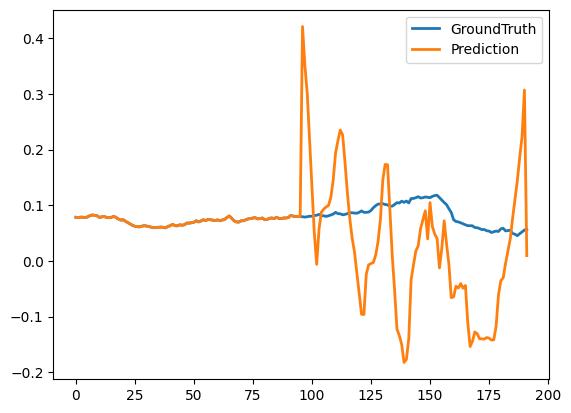

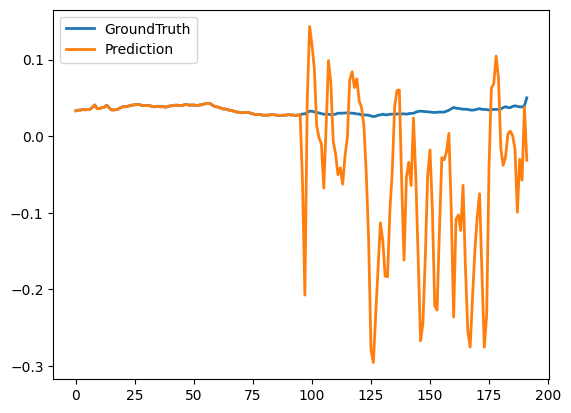

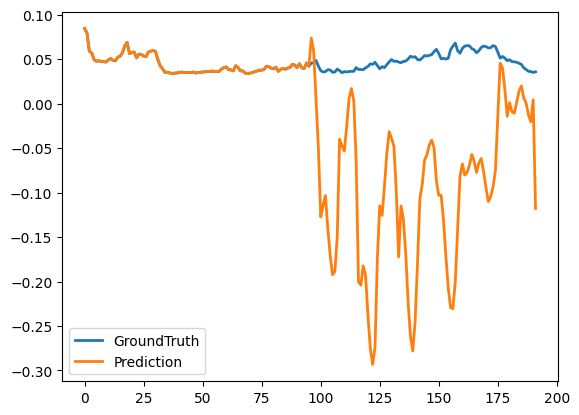

<Figure size 640x480 with 0 Axes>

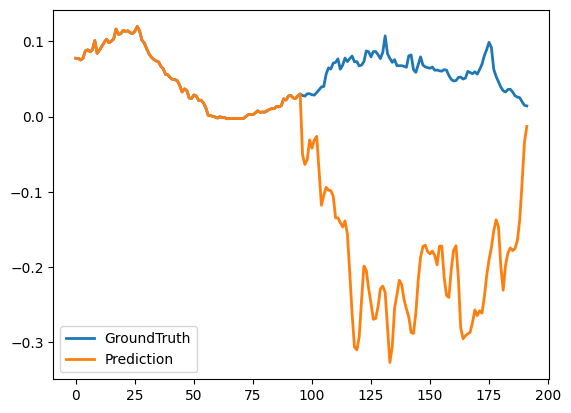

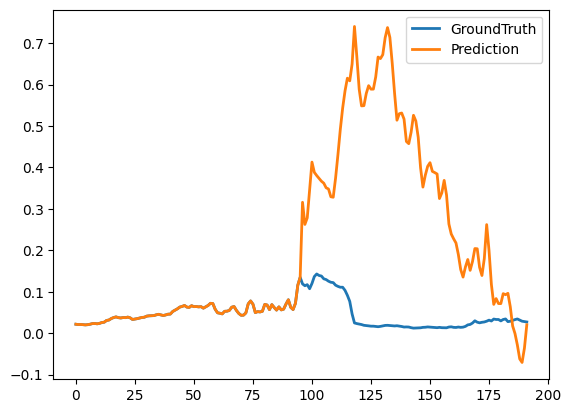

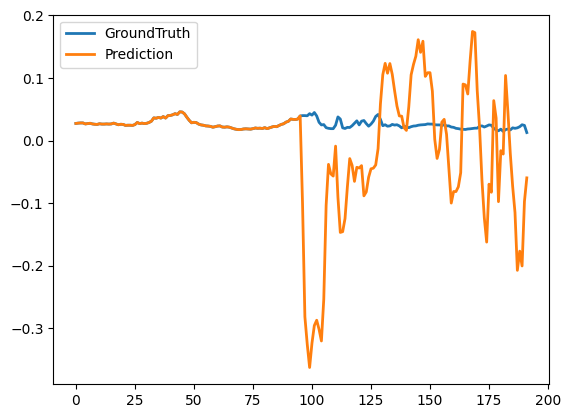

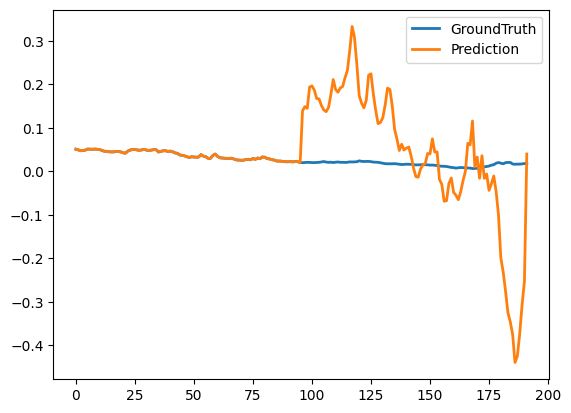

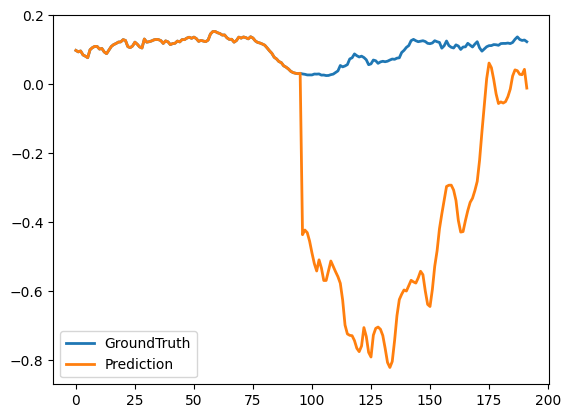

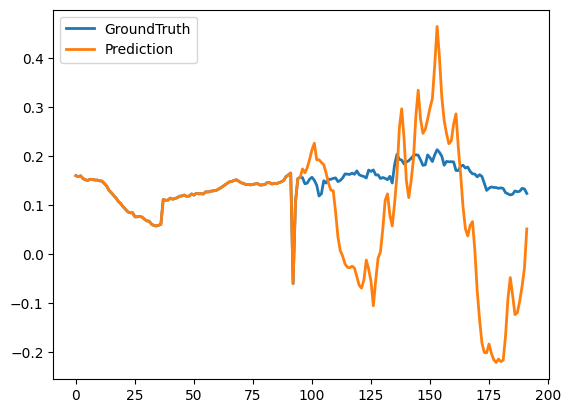

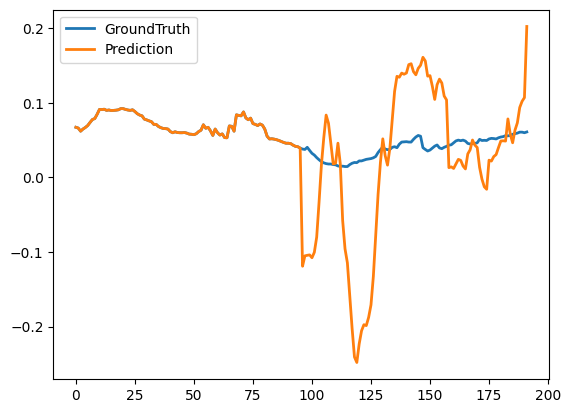

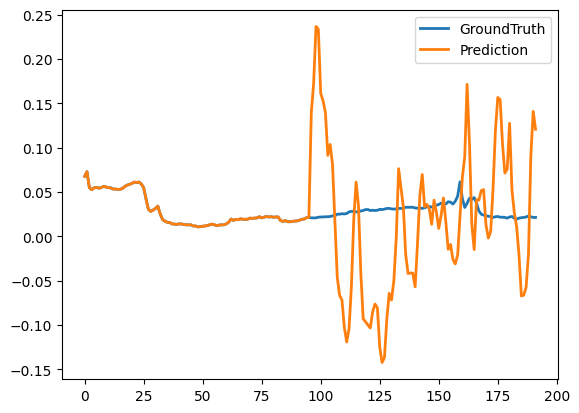

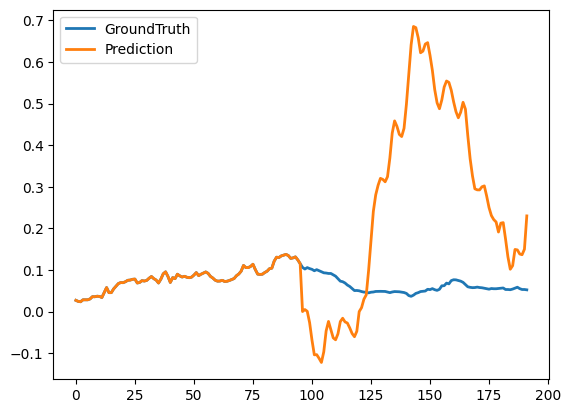

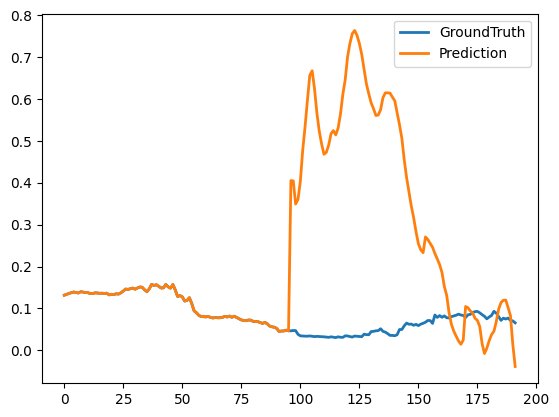

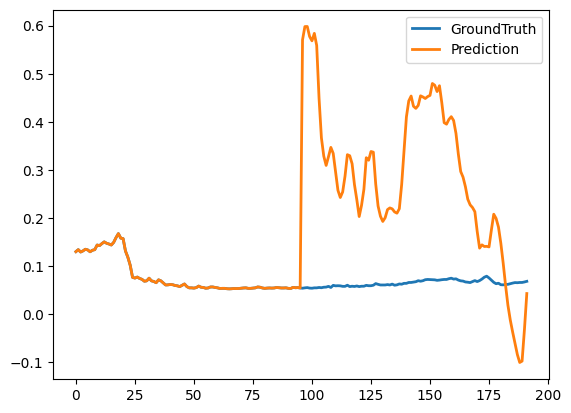

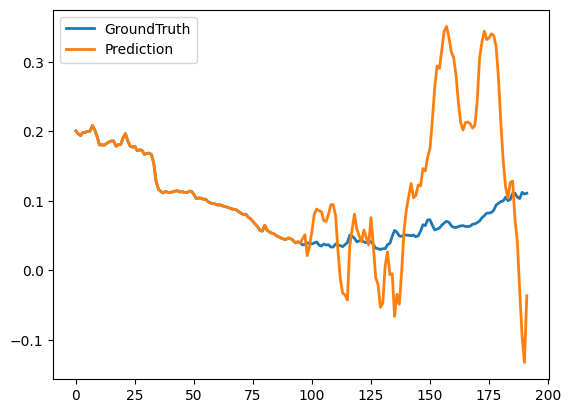

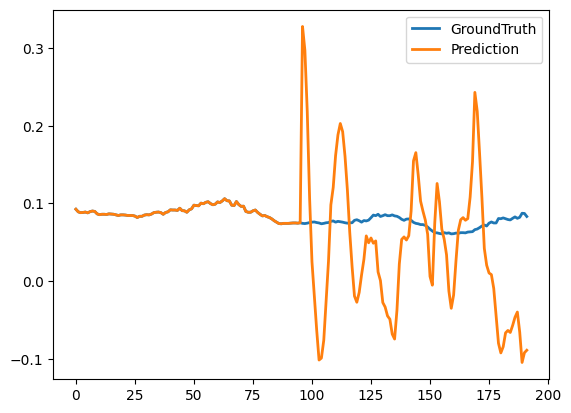

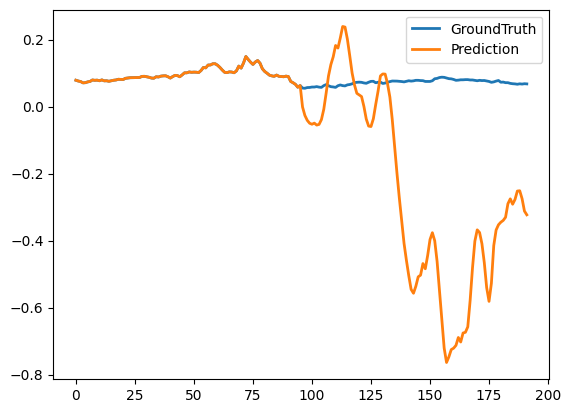

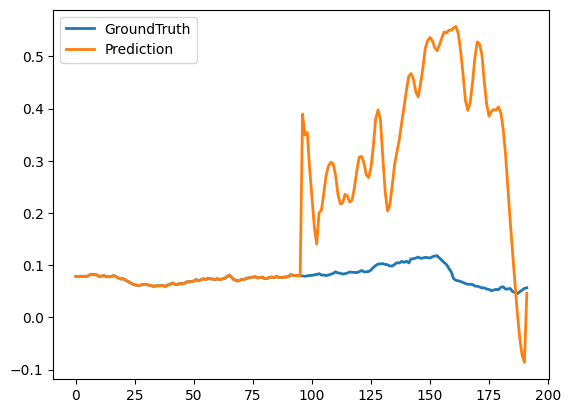

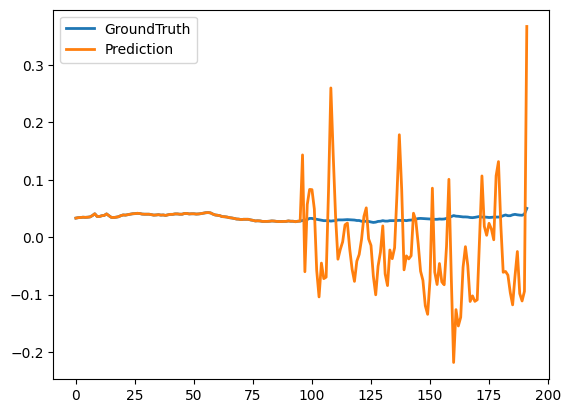

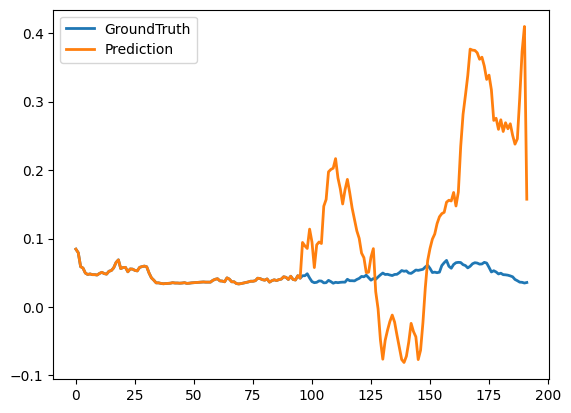

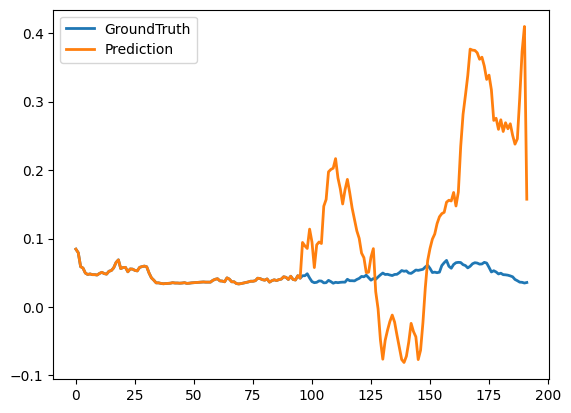

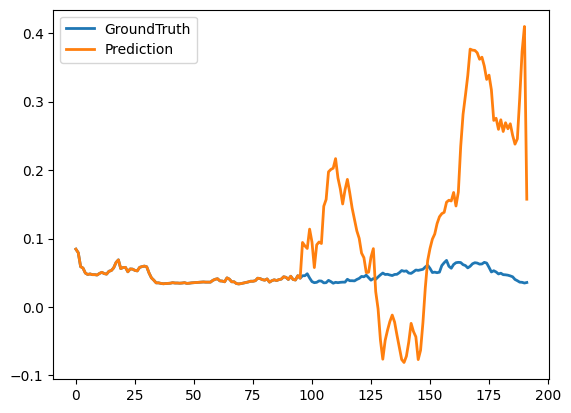

In [19]:
%matplotlib inline
# Exp_autoformer = runrun("Autoformer")
plt.figure()
plt.plot(Exp_autoformer.gt, label='GroundTruth', linewidth=2)
plt.plot(Exp_autoformer.pd, label='Prediction', linewidth=2)
plt.legend()
plt.show()

In [17]:
Exp_autoformer.pd


array([ 0.08450335,  0.07929443,  0.05897966,  0.05689609,  0.04960361,
        0.04752005,  0.04830138,  0.0472596 ,  0.0472596 ,  0.04673871,
        0.04908272,  0.05064539,  0.04882227,  0.04804094,  0.05220807,
        0.05324985,  0.05715654,  0.06496991,  0.06887659,  0.05611476,
        0.05767743,  0.05793788,  0.05142673,  0.05559386,  0.05533342,
        0.0535103 ,  0.05272896,  0.05793788,  0.05897966,  0.059761  ,
        0.05871921,  0.04960361,  0.04257157,  0.03918578,  0.0352791 ,
        0.0352791 ,  0.03449776,  0.03397686,  0.03423731,  0.03449776,
        0.0347582 ,  0.03553954,  0.03501865,  0.03501865,  0.0347582 ,
        0.03501865,  0.03553954,  0.03449776,  0.0347582 ,  0.0352791 ,
        0.03553954,  0.03579998,  0.03606043,  0.03632088,  0.03658132,
        0.03632088,  0.03632088,  0.03632088,  0.03892533,  0.04048801,
        0.04126935,  0.038144  ,  0.03788355,  0.03684177,  0.04257157,
        0.04074845,  0.03684177,  0.03684177,  0.03423731,  0.03

In [8]:
Exp_autoformer.args

AttributeError: 'NoneType' object has no attribute 'args'